## Happy Data Year от Росбанка на boosters.pro 20 место

In [70]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, atan2, sqrt
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [84]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import BaggingRegressor

In [3]:
from hyperopt import fmin, tpe, rand, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

In [4]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

Значения таргета очень сильно отличаются в зависимости от сида. Поэтому для подготовки сабмитов используется функция subm_meen_seed.

In [5]:
def subm_meen_seed(regressor, params, X, Y, X_test, runs):
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.20, random_state=42, shuffle = True)
    runs = runs
    results = np.zeros((runs, X_test.shape[0]))
    for i in range(runs):
        clf = regressor(random_state=6+i, **params)
        clf.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], early_stopping_rounds=5, verbose=False)
        results[i, :]=clf.predict(X_test)
    submit = pd.DataFrame(results.mean(axis=0), index=test.index,columns=['target'])
    
    return submit

In [6]:
#Данных мало. Для оценки качества используются фолды с повторениями
kf = KFold(n_splits = 10, shuffle=True, random_state=42)
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

Данные в трейне и тесте (после долгих колебаний) были почищены вручную с использованием https://ahunter.ru/site/demo/address . 
Пробовала использовать geolocator.geocode. Но он плохо распознает адреса, даже после обработки.
После визуальной проверки данных, заметила в русских адресах болото, реки и т.д. Встречались адреса из Санкт-Петербурга, определяемые как московские. Поскольку все остальные фичи строятся на основе адреса решила, что время потраченное на ручную обработку окупится точностью прогнозов.

Открытые данные сбербанка в sber_5_18. Последние доступные на май 2018 года. Хорошие результаты дают расходы по картам, рублей на расчетном счете, срадняя зарплаат по региону (на выбор). Плюс в эту таблицу добавлена плотность населения по реионам (таблица откуда-то из интернета)
Для крыма скопировала данные по Калмыкии.

Таблица отделений с сайта росбанка в otdel_rosbank. Только для тех городов, которые встречаются в данных. Скопировано вручную. Отделения других банков использовать не стала, т.к. чтобы пользоваться банкоматами Росбанка, надо сначала где-то открыть в них счет. ЕСли нет отделений в городе (или поблизости), то шанс, что в городе есть клиенты банка очень мал.

Данные о центре города в X_city. Первоначально таблица с городом и областью получена при выборе признаков. Потом она была сохранена и доплнена координатами центра горда с сайта ahunter.ru.

In [7]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)
sber = pd.read_csv('data/sber_5_18.csv', index_col=0)
otdel_rosbank = pd.read_csv('data/otdel_rosbank.csv', index_col=0)
X_city = pd.read_csv('data/X_city.csv', index_col=0)

In [8]:
train['isTrain'] = True
test['isTrain'] = False
X = train.append(test, sort=False)

In [9]:
#избавление от 0,5 в названиях некоторых групп
X['atm_group'] = X['atm_group'].astype(int)

### Расстояния до ближайших банкоматов и отделений Росбанка

In [10]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [11]:
knc = KNeighborsClassifier(metric=distance)

In [12]:
dots = X[['lat','long']].dropna()

In [13]:
knc.fit(X=dots, y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x7fdc9097f400>,
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [14]:
distances, indexes = knc.kneighbors(X=dots, n_neighbors=6,)

In [15]:
#лучший результат для 4-5 точек
for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

In [16]:
#со средним было хуже, чем с вариацией
#dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)
dots['var'] = dots.iloc[:,dots.columns.str.contains('distance')].var(axis=1)

In [17]:
#Отделения Росбанка
dots_otdel = otdel_rosbank[['lat','long']].dropna()

In [18]:
neighbors = NearestNeighbors(metric=distance).fit(dots_otdel)

In [19]:
#зона, в окресностях которой ищем банкоматы
X_zone = X[['lat','long']].values

In [20]:
#признак вида "расстояние до ближайших K отделений"
#лучший результат для к=4
distances_o, indexes_o = neighbors.kneighbors(X=X_zone, n_neighbors=5)

In [21]:
for i in range(1,5):
    dots['distance_o_%s'%i] = distances_o[:,i]
    dots['indexes_o_%s'%i] = indexes_o[:,i]

In [22]:
# признак вида "количество точек в радиусе R"
# лучший результат для радиусов 0,1 и 1
distances_r_1, indexes_r_1 = neighbors.radius_neighbors(X=X_zone, radius=0.1)
distances_r_10, indexes_r_10 = neighbors.radius_neighbors(X=X_zone, radius=1.0)

In [23]:
dots['indexes_r_1'] = np.array([len(x) for x in indexes_r_1])
dots['indexes_r_10'] = np.array([len(x) for x in indexes_r_10])

In [24]:
dots = dots.drop(['lat','long'], axis=1)
X = pd.concat([X, dots], axis=1)

### Информация по городу и региону размещения

In [25]:
#Открытые данные сбербанка за май 2018 года и данные по плотности населения по регионам россии в 2017 году
#подходят "зарплата", "расходы по картам", но лучше всего "рублей на текущем счете"
sber = sber.reset_index()
#sber.head()

In [26]:
#Сохранила города в отдельный файл и добавила координацы центра города
X_city = X_city.reset_index()
#X_city.head()

In [27]:
#город и область по текущим данным
#str.strip() удяляет пробелы в начале и конце строки
X['city'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2]).str.strip() 
X['obl'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[3]). str.strip()

In [28]:
X_1 = X.merge(sber, on='obl', how='left', sort=False)
X = pd.merge(X_1, X_city, how='left', left_on=['city','obl'], right_on = ['city','obl'], sort=False)

In [29]:
X_encoded = pd.get_dummies(X, columns = ['atm_group'], prefix='atm_group') #, drop_first=True
#X_encoded.head()

In [30]:
X_new = X.join(X_encoded[['atm_group_32', 'atm_group_496', 'atm_group_1022', 'atm_group_1942', 'atm_group_3185',
                         'atm_group_5478', 'atm_group_8083']], how='left', sort=False)

In [31]:
#Дистнция до центра города
def dist_calc(lat1, lon1, lat2, lon2):
    R = 6373.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    return R * c

In [32]:
X_new['distance_c'] = X.apply(lambda X: dist_calc(X.lat, X.long, X.lat_c, X.long_c), axis=1)

In [33]:
#Средние значения пo группам (подобраны интуитивно - по графикам распределения по группам)
X_new['median'] = X_new['atm_group'].replace(5478, -0.034).replace(1942, 0.004).replace(8083, 0.151)\
                        .replace(496, -0.048).replace(3185, -0.044).replace(1022, -0.089).replace(32, 0.008)

## Обучающая выборка

In [34]:
#atm_group - похоже на ранги популярности, оставляем как числовой признак 
#Для категорий - закодированные с get_dummies
X_ = X_new[X_new.isTrain][['atm_group', 'lat', 'long', 'distance_4', 'distance_5', 'indexes_5', 'var',
                           'rub_chet', 'distance_o_4', 'indexes_o_4', 'indexes_r_1', 'indexes_r_10', 
                           'plot_nas_17','distance_c', 'median', 'atm_group_496', 'atm_group_1022', 
                           'atm_group_1942', 'atm_group_3185', 'atm_group_5478', 'atm_group_8083']]
Y_ = X.loc[X.isTrain, 'target']

In [35]:
X_test = X_new[~X_new.isTrain][['atm_group', 'lat', 'long', 'distance_4', 'distance_5', 'indexes_5', 'var',
                           'rub_chet', 'distance_o_4', 'indexes_o_4', 'indexes_r_1', 'indexes_r_10', 
                           'plot_nas_17','distance_c', 'median', 'atm_group_496', 'atm_group_1022', 
                           'atm_group_1942', 'atm_group_3185', 'atm_group_5478', 'atm_group_8083']]

In [38]:
#Сохраняем обучающую выборку
X_.to_csv('data/X_train.csv', encoding='utf-8', index=True)
X_test.to_csv('data/X_test.csv', encoding='utf-8', index=True)
Y_.to_csv('data/Y_train.csv', encoding='utf-8', index=True)

## Подготовка сабмитов по отдельным моделям: LGBMRegressor, CatBoostRegressor, XGBRegressor

In [39]:
#lgb_params частично подобраны hyperopt
lgb_params = {'objective' : 'regression', 'metric' : 'rmse', 'subsample' : 0.8,
              'learning_rate': 0.03575452711507229, 'max_depth': 10, 'n_estimators': 333, 'num_leaves': 49}

In [40]:
submit_lgbr = subm_meen_seed(LGBMRegressor, lgb_params, X_, Y_, X_test, 100)
submit_lgbr_log = np.expm1(subm_meen_seed(LGBMRegressor, lgb_params, X_, np.log1p(Y_), X_test, 100))
#submit_lgbr_plus = subm_meen_seed(LGBMRegressor, lgb_params, X_, (Y_ + 0.15), X_test, 100) - 0.15

In [41]:
#cat_params частично подобраны hyperopt. Считает долго, поэтому 10 раз, а не 100
cat_params = {'loss_function': 'RMSE', 'bootstrap_type': 'Poisson', 'subsample': 0.8, "task_type" : 'GPU',
              'verbose': 0, 'depth': 12, 'iterations': 499, 'learning_rate': 0.08564751357369907}

In [42]:
submit_cat = subm_meen_seed(CatBoostRegressor, cat_params, X_, Y_, X_test, 10)
submit_cat_log = np.expm1(subm_meen_seed(CatBoostRegressor, cat_params, X_, np.log1p(Y_), X_test, 10))
#submit_cat_plus = subm_meen_seed(CatBoostRegressor, cat_params, X_, (Y_ + 0.15), X_test, 100) - 0.15

In [43]:
#xgbr_params частично подобраны hyperopt
xgbr_params = {'objective':'reg:linear', 'colsample_bytree': 0.8, "tree_method": 'gpu_hist', 
               'learning_rate': 0.04387542177046786, 'max_depth': 8, 'min_child_weight': 2, 
               'n_estimators': 165, 'reg_lambda': 0.3891187405173641}

In [44]:
submit_xgbr = subm_meen_seed(XGBRegressor, xgbr_params, X_, Y_, X_test, 100)
submit_xgbr_log = np.expm1(subm_meen_seed(XGBRegressor, xgbr_params, X_, np.log1p(Y_), X_test, 100))
#submit_xgbr_plus = subm_meen_seed(XGBRegressor, xgbr_params, X_, (Y_ + 0.15), X_test, 100) - 0.15

## Простое усреднение моделей

In [45]:
#Новый датафрейм для результатов моделей
new_df = pd.DataFrame(index=test.index)
new_df['lgbr'] = submit_lgbr
new_df['lgbr_log'] = submit_lgbr_log
#new_df['lgbr_plus'] = submit_lgbr_plus
new_df['cat'] = submit_cat
new_df['cat_log'] = submit_cat_log
#new_df['cat_plus'] = submit_cat_plus
new_df['xgbr'] = submit_xgbr
new_df['xgbr_log'] = submit_xgbr_log
#new_df['xgbr_plus'] = submit_xgbr_plus
prediction = new_df.mean(axis=1)
#new_df.head()

In [46]:
#0.044171
submit = pd.DataFrame(prediction, index=test.index,columns=['target'])
submit.to_csv('submit_mean.csv')

# StackingRegressor

In [47]:
ridge = Ridge(alpha=1, random_state=42)
gbm = LGBMRegressor(**lgb_params, random_state=42)
cat = CatBoostRegressor(**cat_params, random_state=42)
xgbr = XGBRegressor(**xgbr_params, random_state=42)

In [49]:
stack = StackingRegressor(regressors=(gbm, cat, xgbr), meta_regressor=ridge)
stack.fit(X_, Y_)

StackingRegressor(meta_regressor=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001),
         refit=True,
         regressors=(LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.03575452711507229,
       max_depth=10, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=333,
       n_jobs=-1,...641,
       scale_pos_weight=1, seed=None, silent=True, subsample=1,
       tree_method='gpu_hist')),
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

In [50]:
#Паблик 0.043659, приват 0.042549
submit_stack = pd.DataFrame(stack.predict(X_test), index=test.index,columns=['target'])
submit_stack.to_csv('submit_stack.csv')

# Дополнительно

Далее описывается подбор гиперпараметров, оценки данных и моделей

## Подбор гиперпараметров
## LGBMRegressor

In [51]:
# Для подбора использовался max_evals = 300-500
def objective(params):
    params = {
        'learning_rate' :float(params['learning_rate']),
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),                  #-1 means no limit.
        'num_leaves': int(params['num_leaves']),                 #листьев умолчание 31  д.б. < 2^(max_depth)
    }
    
    model = LGBMRegressor(
        objective = 'regression',
        metric = 'rmse',
        random_state=42,
        colsample_bytree = 0.8, 
        subsample = 0.8,
        device='gpu',
        **params     
    )
    
    score = np.sqrt(-1*cross_val_score(model, X_, Y_, scoring='neg_mean_squared_error', cv=kf)).mean()
    print("score {:.5f} params {}".format(score, params))
    return score

space = {
    'learning_rate' : hp.uniform('learning_rate', 0.02, 0.04),             
    'n_estimators': hp.quniform('n_estimators', 100, 350, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),        
    'num_leaves': hp.quniform('num_leaves', 25, 65, 1),
}

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=3, trials=trials)

score 0.04337 params {'learning_rate': 0.03594220615785177, 'n_estimators': 157, 'max_depth': 9, 'num_leaves': 30}
score 0.04403 params {'learning_rate': 0.027860080782217023, 'n_estimators': 317, 'max_depth': 4, 'num_leaves': 51}
score 0.04290 params {'learning_rate': 0.033214152606423644, 'n_estimators': 290, 'max_depth': 10, 'num_leaves': 45}


In [52]:
print (min(trials.losses()))
print("Оптимальные параметры: {}".format(space_eval(space, best)))

0.042896906762391045
Оптимальные параметры: {'learning_rate': 0.033214152606423644, 'max_depth': 10.0, 'n_estimators': 290.0, 'num_leaves': 45.0}


## CatBoostRegressor

In [53]:
def objective(params):
    params = {
        'learning_rate' :float(params['learning_rate']),
        'iterations': int(params['iterations']),
        'depth': int(params['depth']),
    }
    
    model = CatBoostRegressor(
        random_state=42,
        verbose=0,
        loss_function = 'RMSE',
        boosting_type='Ordered',
        leaf_estimation_iterations=1,
        **params
    )
    
    score = np.sqrt(-1*cross_val_score(model, X_, Y_, scoring='neg_mean_squared_error', cv=3)).mean()
    print("score {:.5f} params {}".format(score, params))
    return score

space = {
    'learning_rate' : hp.uniform('learning_rate', 0.08, 0.1),             
    'iterations': hp.quniform('iterations', 450, 550, 1),
    'depth': hp.quniform('depth', 9, 13, 1),
}

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=1, trials=trials)

score 0.04489 params {'learning_rate': 0.08599184317802548, 'iterations': 467, 'depth': 9}


In [54]:
print (min(trials.losses()))
print("Оптимальные параметры: {}".format(space_eval(space, best)))

0.044893783022214286
Оптимальные параметры: {'depth': 9.0, 'iterations': 467.0, 'learning_rate': 0.08599184317802548}


## XGBRegressor

In [56]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_child_weight': int(params['min_child_weight']),
        'learning_rate' :float(params['learning_rate']),   
        'n_estimators': int(params['n_estimators']),
        'reg_lambda': float(params['reg_lambda'])
    }
    
    model = XGBRegressor(
        objective='reg:linear',
        colsample_bytree=0.8,
        random_state=4,
        tree_method='gpu_hist',  
        **params
    )
    
    score = np.sqrt(-1*cross_val_score(model, X_, Y_, scoring='neg_mean_squared_error', cv=rkf)).mean()
    print("score {:.6f} params {}".format(score, params))
    return score

#зададим пространство поиска
space = {
    'max_depth': hp.quniform('max_depth', 7, 8, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
    'learning_rate' : hp.uniform('learning_rate', 0.03, 0.05),             
    'n_estimators': hp.quniform('n_estimators', 120, 190, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 0.4)                #l2
}

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=3, trials=trials)

score 0.043291 params {'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.046217175139859915, 'n_estimators': 141, 'reg_lambda': 0.16694778925967885}
score 0.043630 params {'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.032275667746031855, 'n_estimators': 144, 'reg_lambda': 0.2823468973906422}
score 0.043274 params {'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.04204331388996369, 'n_estimators': 133, 'reg_lambda': 0.3753150462315914}


In [57]:
print (min(trials.losses()))
print("Оптимальные параметры: {}".format(space_eval(space, best)))

0.043274037551711296
Оптимальные параметры: {'learning_rate': 0.04204331388996369, 'max_depth': 8.0, 'min_child_weight': 2.0, 'n_estimators': 133.0, 'reg_lambda': 0.3753150462315914}


## Bagging
почти не дал результата, не стала использовать

In [58]:
X_train_, X_valid_, Y_train_, Y_valid_ = train_test_split(X_, Y_, test_size=0.25, random_state=42, shuffle = True)
bgbm = BaggingRegressor(base_estimator = xgbr, n_estimators=10, max_samples=0.5, max_features=X_.shape[1], random_state=42,
                         bootstrap = True, bootstrap_features = True, oob_score = False)

In [59]:
scores = np.sqrt(-1*cross_val_score(bgbm, X_, Y_, scoring='neg_mean_squared_error', cv=kf)).mean()
print(scores)

0.04329260936852442


In [60]:
bgbm.fit(X_train_, Y_train_)
rmse(Y_valid_, bgbm.predict(X_valid_))

0.043109123629196174

In [61]:
bgbm.fit(X_, Y_)
submit_bgbm = pd.DataFrame(bgbm.predict(X_test), index=test.index, columns=['target'])

## Анализ данных

In [62]:
import pandas_profiling

In [63]:
pandas_profiling.ProfileReport(X_)

Number of variables,21
Number of observations,6261
Total Missing (%),0.0%
Total size in memory,819.3 KiB
Average record size in memory,134.0 B
Numeric,14
Categorical,0
Boolean,5
Date,0
Text (Unique),0
Rejected,2


In [64]:
pandas_profiling.ProfileReport(X_test)

Number of variables,22
Number of observations,2504
Total Missing (%),0.0%
Total size in memory,327.8 KiB
Average record size in memory,134.0 B
Numeric,15
Categorical,0
Boolean,5
Date,0
Text (Unique),0
Rejected,2


### Партнеры Росбанка (с сайта):  
Альфа-Банк  
ВТБ  
УРАЛСИБ БАНК  
АК Барс Банк  
Райффайзенбанк  
Россельхозбанк  
Газпромбанк  

### Определение групп:  
5478 ВТБ (Уралсиб?)  
1942 Альфабанк+  
8083 Росбанк+  
496.5 Розсельхозбанк+  
3185.5 Газпромбанк  
1022 Ак Барс Банк+  
32 Прочее  

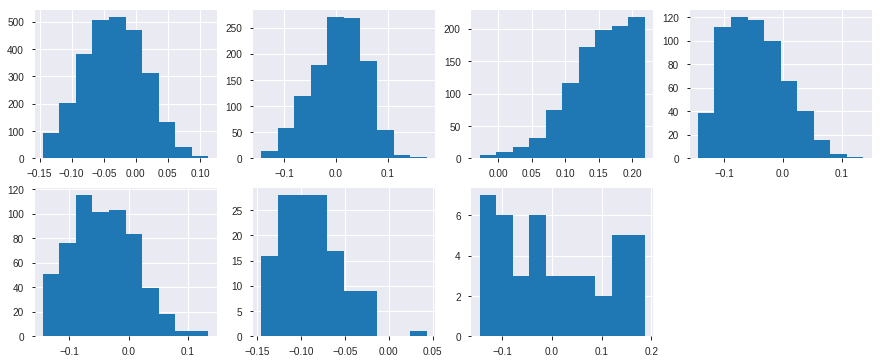

In [71]:
#Распределение внутри групп банков
plt.figure(figsize=(15,6))
plt.subplot(241)
train['target'][train.atm_group == 5478].hist()

plt.subplot(242) 
train['target'][train.atm_group == 1942].hist()

plt.subplot(243) 
train['target'][train.atm_group == 8083].hist()

plt.subplot(244) 
train['target'][train.atm_group == 496.5].hist()

plt.subplot(245) 
train['target'][train.atm_group == 3185.5].hist()

plt.subplot(246) 
train['target'][train.atm_group == 1022].hist()

plt.subplot(247) 
train['target'][train.atm_group == 32].hist()
plt.show()

In [72]:
atm_group_df = pd.DataFrame(index=train.index)
atm_group_df['atm_group'] = train.atm_group
atm_group_df['target'] = train.atm_group

atm_group_df['target'] = atm_group_df['target'].replace(5478, -0.034).replace(1942, 0.004).replace(8083, 0.151)\
                        .replace(496.5, -0.048).replace(3185.5, -0.044).replace(1022, -0.089).replace(32, 0.008)

In [73]:
rmse(Y_, atm_group_df['target'])

0.04960726000213258

In [74]:
train['atm_group'].value_counts()

5478.0    2662
1942.0    1160
8083.0    1050
496.5      616
3185.5     594
1022.0     136
32.0        43
Name: atm_group, dtype: int64

In [75]:
test['atm_group'].value_counts()

5478.0    1067
1942.0     486
8083.0     404
496.5      247
3185.5     232
1022.0      49
32.0        19
Name: atm_group, dtype: int64

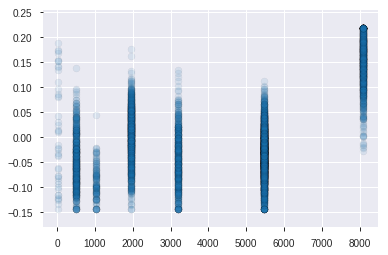

In [76]:
fig, ax = plt.subplots()
ax.scatter(train['atm_group'], train['target'], edgecolors=(0, 0, 0), alpha=0.1)
plt.show()

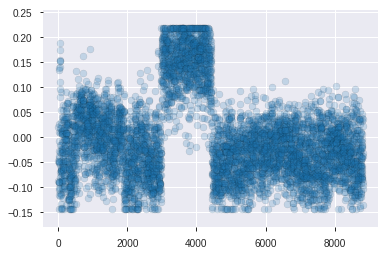

In [77]:
fig, ax = plt.subplots()
ax.scatter(train['id'], train['target'], edgecolors=(0, 0, 0), alpha=0.2)
plt.show()

## Оценка моделей

In [78]:
#Кроссваидация по моделям
stack = StackingRegressor(regressors=(gbm, cat, xgbr), meta_regressor=ridge)

print('Cross validation scores:\n')

for clf, label in zip([gbm, cat, xgbr, stack], ['LGBMRegressor', 'CatBoostRegressor', 
                                                'XGBRegressor', 'StackingRegressor']):
    scores = np.sqrt(-1*cross_val_score(clf, X_, Y_, scoring='neg_mean_squared_error', cv=kf))
    print("RMSE Score: %0.6f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), label))

Cross validation scores:

RMSE Score: 0.043097 (+/- 0.00187) [LGBMRegressor]
RMSE Score: 0.043341 (+/- 0.00171) [CatBoostRegressor]
RMSE Score: 0.042771 (+/- 0.00172) [XGBRegressor]
RMSE Score: 0.042925 (+/- 0.00183) [StackingRegressor]


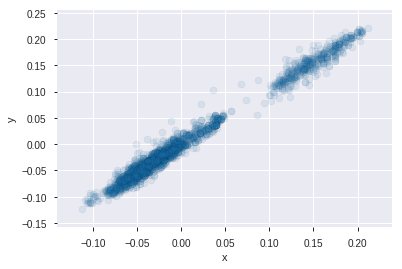

In [79]:
#Простое усреднение и стэкинг - сравнение
x = prediction
y = submit_stack
fig, ax = plt.subplots()
ax.scatter(x, y, edgecolors=(0, 0, 0), alpha=0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

CV - LB Diff: 0.0010


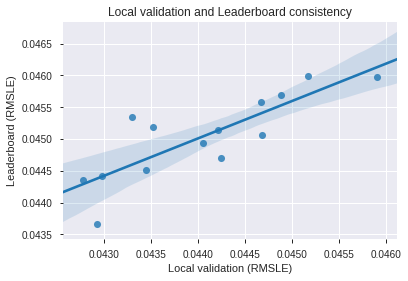

In [95]:
#сравнение кроссвалидации и паблика
cv_lb = pd.DataFrame({'cv': [0.045168, 0.044877, 0.045905, 0.044682, 0.044668, 0.044214, 0.0442457, 0.0434409, 
                             0.042973, 0.043301, 0.043523, 0.044050, 0.042771, 0.042925],
                      'lb': [0.045999,0.045689, 0.045983, 0.045062, 0.045590, 0.045147, 0.044698, 0.044519, 
                             0.044415, 0.045354, 0.045185, 0.044935, 0.044362, 0.043659]})
ax = sns.regplot(x="cv", y="lb", data=cv_lb, scatter_kws={'s': 50})
ax.set_xlabel('Local validation (RMSLE)')
ax.set_ylabel('Leaderboard (RMSLE)')
ax.set_title('Local validation and Leaderboard consistency')
print('CV - LB Diff: %.4f' % np.mean(cv_lb['lb'] - cv_lb['cv']))

pablic - private Diff: 0.0013


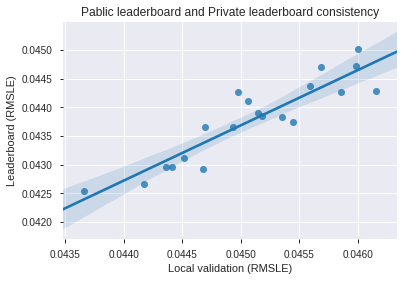

In [97]:
#сравнение паблика и привата
all_lb = pd.DataFrame({'pablic': [0.0436585, 0.0441712, 0.0446766, 0.044415, 0.0443625, 0.0445186, 0.0446977, \
                                  0.0449351, 0.0454482, 0.0453545, 0.0451851, 0.0451469, 0.0450624, 0.0458581,\
                                  0.0449794, 0.0461566, 0.0455901, 0.0456886, 0.0459835, 0.0459988],
                      'private': [0.0425493, 0.0426609, 0.0429188, 0.0429528, 0.042968, 0.0431223, 0.0436534,\
                                 0.0436543, 0.0437434, 0.0438347, 0.0438467, 0.0438973, 0.0441165, 0.0442598,\
                                 0.0442636, 0.044282, 0.0443738, 0.0446938, 0.0447266, 0.0450123]})
ax = sns.regplot(x="pablic", y="private", data=all_lb, scatter_kws={'s': 50})
ax.set_xlabel('Local validation (RMSLE)')
ax.set_ylabel('Leaderboard (RMSLE)')
ax.set_title('Pablic leaderboard and Private leaderboard consistency')
print('pablic - private Diff: %.4f' % np.mean(all_lb['pablic'] - all_lb['private']))

## Важность признаков

In [82]:
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import plot_importance

Text(0.5, 1.0, 'LightGBM - Feature Importance')

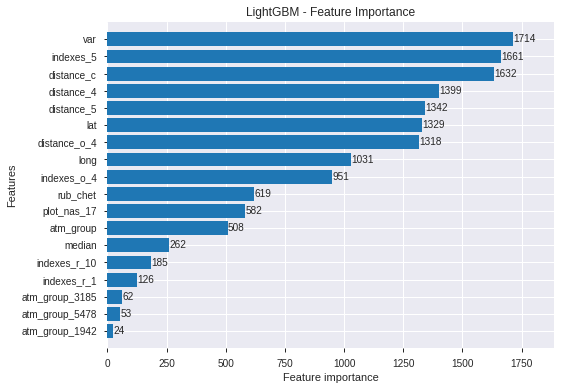

In [85]:
gbm.fit(X_, Y_)

fig, ax = plt.subplots(figsize=(8, 6))
lgb.plot_importance(gbm, height=0.8, ax=ax)
plt.title("LightGBM - Feature Importance")

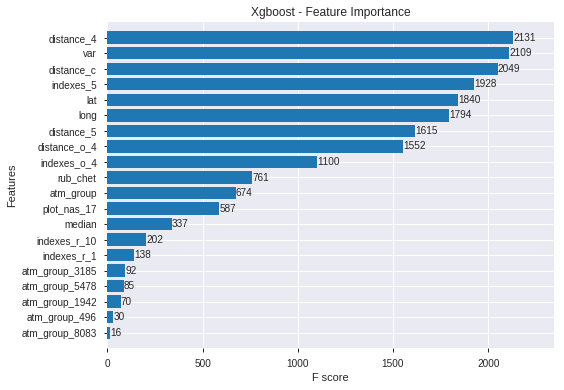

In [86]:
xgbr.fit(X_, Y_)

fig, ax = plt.subplots(figsize=(8,6))
plot_importance(xgbr, max_num_features=20, height=0.8, ax=ax)
plt.title("Xgboost - Feature Importance")
plt.show()

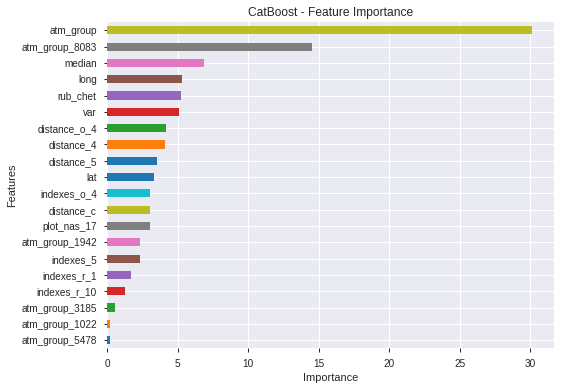

In [87]:
cat.fit(X_, Y_)

fea_imp = pd.DataFrame({'imp': cat.feature_importances_, 'col': X_.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(8, 6), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [88]:
feature_names = list(X_)

In [89]:
X_matrix = X_.values
Y_matrix = Y_.values

X_train, X_valid, Y_train, Y_valid = train_test_split(X_matrix, Y_matrix, test_size=0.2, random_state=42, shuffle = True)

In [90]:
gbm.fit(X_train, Y_train)
perm = PermutationImportance(gbm).fit(X_valid, Y_valid)
eli5.show_weights(perm, feature_names = feature_names)

Weight,Feature
1.0300 ± 0.0606,atm_group
0.0751 ± 0.0114,median
0.0400 ± 0.0048,var
0.0374 ± 0.0079,distance_5
0.0291 ± 0.0047,rub_chet
0.0170 ± 0.0034,indexes_o_4
0.0162 ± 0.0023,plot_nas_17
0.0153 ± 0.0039,distance_4
0.0137 ± 0.0055,distance_o_4
0.0121 ± 0.0040,long


In [91]:
xgbr.fit(X_train, Y_train)
perm = PermutationImportance(xgbr).fit(X_valid, Y_valid)
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.6060 ± 0.0310,atm_group
0.1218 ± 0.0109,median
0.0265 ± 0.0074,var
0.0244 ± 0.0036,distance_5
0.0173 ± 0.0017,long
0.0156 ± 0.0030,distance_o_4
0.0140 ± 0.0021,rub_chet
0.0134 ± 0.0025,plot_nas_17
0.0117 ± 0.0036,distance_4
0.0109 ± 0.0050,lat


In [92]:
cat.fit(X_train, Y_train)
perm = PermutationImportance(cat).fit(X_valid, Y_valid)
eli5.show_weights(perm, feature_names = feature_names)

Weight,Feature
-0.0002 ± 0.0001,atm_group_3185
-0.0002 ± 0.0002,atm_group_1022
-0.0003 ± 0.0001,indexes_5
-0.0005 ± 0.0002,lat
-0.0005 ± 0.0001,atm_group_496
-0.0007 ± 0.0002,distance_c
-0.0007 ± 0.0002,indexes_r_10
-0.0007 ± 0.0003,indexes_r_1
-0.0007 ± 0.0001,indexes_o_4
-0.0011 ± 0.0003,distance_4
